In [17]:
# 12.1 Case Study: Predicting Successful Grant Applications
Sys.setlocale("LC_TIME", "English")

library(parallel)
setDefaultCluster(makeCluster(4))
source('CreateGrantData.R')
save(training,testing,pre2008,fullSet,reducedSet,file = "grant_Data.Rdata")

[1] "English_United States.1252"

 chr [1:1073] "NumCI" "NumDR" "NumECI" "NumEA" "NumHV" "NumPS" "NumSCI" ...
 chr [1:252] "NumCI" "NumDR" "NumECI" "NumPS" "NumSCI" "NumSR" "NumUNK" ...


`there are 1073 predictors in fullSet, However the book show only 1070 predictors @page 311`

In [30]:
reducedCovMat <- cov(training[,reducedSet])
library(subselect)
trimmingResults <- trim.matrix(reducedCovMat)
names(trimmingResults)
trimmingResults$names.discarded

[1] "trimmedmat"        "numbers.discarded" "names.discarded"  
[4] "size"

In [34]:
#apply to full set
fullCovMat <- cov(training[,fullSet])
fullSetResults <- trim.matrix(fullCovMat)
fullSetResults$names.discarded

[1] "NumDR"       "PS.1975"     "CI.Dept1798" "PS.Dept3028" "PS.Faculty1"
[6] "BTotal"      "numPeople"   "Apr"         "Sun"

In [1]:
load("grantData.RData")

In [3]:
levels(training$Class)

[1] "successful"   "unsuccessful"

In [4]:
library(caret)
fit_glt <- glm(Class~Day,
              data=training[pre2008,],
              family=binomial)
fit_glt

Loading required package: lattice
Loading required package: ggplot2



Call:  glm(formula = Class ~ Day, family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day  
    -0.3660       0.0267  

Degrees of Freedom: 6632 Total (i.e. Null);  6631 Residual
Null Deviance:	    9191 
Residual Deviance: 9103 	AIC: 9107

In [5]:
successProb <- 1- predict(
                          fit_glt,
                          newdata = data.frame(Day=c(10,150,300,350)),
                         type="response")

successProb

1            2            3            4 
0.5247346981 0.0256165067 0.0004790980 0.0001261416

In [7]:
fit_daySquared <- glm(
                      Class~Day + I(Day^2),
                     data=training[pre2008,],
                     family=binomial)
fit_daySquared


Call:  glm(formula = Class ~ Day + I(Day^2), family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day     I(Day^2)  
  -1.050342     0.165185    -0.004645  

Degrees of Freedom: 6632 Total (i.e. Null);  6630 Residual
Null Deviance:	    9191 
Residual Deviance: 8903 	AIC: 8909

In [9]:
library(rms)
fit_rcs <- lrm(Class~rcs(Day),data=training[pre2008,])
fit_rcs

Logistic Regression Model
 
 lrm(formula = Class ~ rcs(Day), data = training[pre2008, ])
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs          6633    LR chi2     324.93    R2       0.064    C       0.596    
  successful  3233    d.f.             4    g        0.453    Dxy     0.192    
  unsuccessful3400    Pr(> chi2) <0.0001    gr       1.573    gamma   0.204    
 max |deriv| 1e-10                          gp       0.108    tau-a   0.096    
                                            Brier    0.238                     
 
           Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept -1.2946 0.0894 -14.48 <0.0001 
 Day        0.2316 0.0183  12.67 <0.0001 
 Day'      -0.7221 0.0825  -8.76 <0.0001 
 Day''      2.5730 0.3564   7.22 <0.0001 
 Day'''    -4.7924 0.8021  -5.97 <0.0001 
 

In [12]:
max(training[pre2008,'Day'])

[1] 31

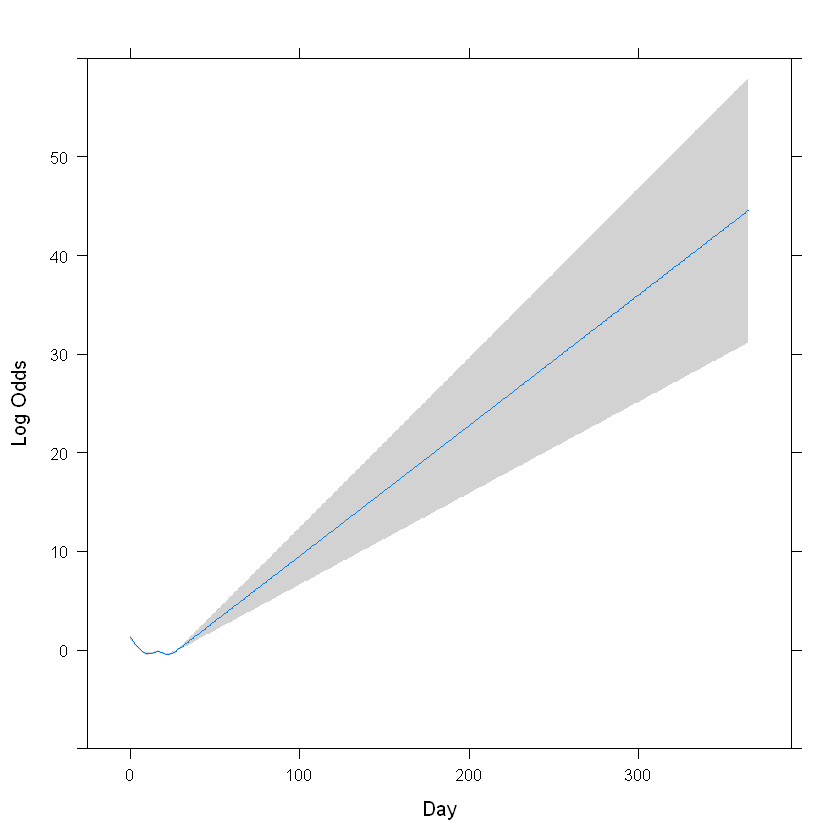

In [15]:
dayProfile <- Predict(fit_rcs,Day=0:365,fun=function(x)-x)
plot(dayProfile,ylab="Log Odds")

```r
### Section 12.1 Case Study: Predicting Successful Grant Applications

load("grantData.RData")

library(caret)
library(doMC)
registerDoMC(12)
library(plyr)
library(reshape2)

## Look at two different ways to split and resample the data. A support vector
## machine is used to illustrate the differences. The full set of predictors
## is used. 

pre2008Data <- training[pre2008,]
year2008Data <- rbind(training[-pre2008,], testing)

set.seed(552)
test2008 <- createDataPartition(year2008Data$Class, p = .25)[[1]]

allData <- rbind(pre2008Data, year2008Data[-test2008,])
holdout2008 <- year2008Data[test2008,]

## Use a common tuning grid for both approaches. 
svmrGrid <- expand.grid(sigma = c(.00007, .00009, .0001, .0002),
                        C = 2^(-3:8))

## Evaluate the model using overall 10-fold cross-validation
ctrl0 <- trainControl(method = "cv",
                      summaryFunction = twoClassSummary,
                      classProbs = TRUE)
set.seed(477)
svmFit0 <- train(pre2008Data[,fullSet], pre2008Data$Class,
                 method = "svmRadial",
                 tuneGrid = svmrGrid,
                 preProc = c("center", "scale"),
                 metric = "ROC",
                 trControl = ctrl0)
svmFit0

### Now fit the single 2008 test set
ctrl00 <- trainControl(method = "LGOCV",
                       summaryFunction = twoClassSummary,
                       classProbs = TRUE,
                       index = list(TestSet = 1:nrow(pre2008Data)))


set.seed(476)
svmFit00 <- train(allData[,fullSet], allData$Class,
                  method = "svmRadial",
                  tuneGrid = svmrGrid,
                  preProc = c("center", "scale"),
                  metric = "ROC",
                  trControl = ctrl00)
svmFit00

## Combine the two sets of results and plot

grid0 <- subset(svmFit0$results,  sigma == svmFit0$bestTune$sigma)
grid0$Model <- "10-Fold Cross-Validation"

grid00 <- subset(svmFit00$results,  sigma == svmFit00$bestTune$sigma)
grid00$Model <- "Single 2008 Test Set"

plotData <- rbind(grid00, grid0)

plotData <- plotData[!is.na(plotData$ROC),]
xyplot(ROC ~ C, data = plotData,
       groups = Model,
       type = c("g", "o"),
       scales = list(x = list(log = 2)),
       auto.key = list(columns = 1))

```